We test whether TDE can enhace prediction abilities of ESNs applied to the Lorenz System.

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


## Simulating Lorenz Data

In [3]:
# Set up the Lorenz system and generate data
lorenz = Systems.lorenz63()

# Integrate the system
T = 200.0
Δt = 0.1
Ttr = 100.0  # Transient that will be discarded

tr = trajectory(lorenz, T, Δt = Δt, Ttr = Ttr)
x, y, z = columns(tr[1])

# Put the data in the matrix format (n_features, n_samples) required by ReservoirComputing.jl 
data = copy(hcat(x, y, z)')

3×2001 Matrix{Float64}:
  -7.9554  -15.3466  -13.1091  -3.50536  …   2.60804   4.85809   9.20262
 -14.5316  -21.0154   -3.5192   3.71577      4.24185   7.98143  14.6799
  12.6248   30.0779   41.0784  30.7804      17.4522   15.3366   18.8447

In [4]:
l_max = lyapunov(lorenz, 100, Ttr = 100)

0.8986638632954478

## Tools

In [ ]:
"""
    train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)

Split the given data into training, validation, and test sets.
"""
function train_val_test_split(data; N_train=5160)
    
    N_val = round(Int, val_seconds / Δt)
    N_test = round(Int, test_seconds / Δt)
    
    ind1 = N - N_test - N_val
    ind2 = N - N_test
    
    train_data = data[:, 1:ind1]
    val_data = data[:, ind1+1:ind2]
    test_data = data[:, ind2+1:end]
    
    return train_data, val_data, test_data
end

train_val_test_split

In [87]:
"""
    plot_prediction_tde_sep(esn_x, esn_y, esn_z, W_x, W_y, W_z, test_data_x,test_data_y,test_data_z, λ_max, title)

plot predictions versus the given test set, when TDE is performed seperately on different observables
"""
function plot_prediction_sep(esn_x, esn_y, esn_z, W_x, W_y, W_z, test_data_x,test_data_y,test_data_z, λ_max, title)
    
    prediction_x = esn_x(Generative(size(test_data_x, 2)), W_x)
    prediction_y = esn_y(Generative(size(test_data_y, 2)), W_y)
    prediction_z = esn_z(Generative(size(test_data_z, 2)), W_z)
    
    label = ["actual" "predicted"]
    times_x = Δt * collect(0:size(test_data_x, 2))[1:end-1] / λ_max
    times_y = Δt * collect(0:size(test_data_y, 2))[1:end-1] / λ_max
    times_z = Δt * collect(0:size(test_data_z, 2))[1:end-1] / λ_max

    print(test_data_z[1,:])

    p1 = plot(times_x, [test_data_x[1, :], prediction_x[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times_y, [test_data_y[1, :], prediction_y[1, :]], label = label, ylabel = "y(t)")
    p3 = plot(times_z, [test_data_z[1, :], prediction_z[1, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600), title=title)
end

plot_prediction_sep

In [39]:
"""
    plot_comparison(esn_1d, esn_tde, W_1d, W_tde, test_data, λ_max, title)

"""
function plot_comparison(esn_1d, esn_tde, W_1d, W_tde, test_data, λ_max, title)

    prediction_size = size(test_data, 2)
    
    prediction_1d = esn_1d(Generative(prediction_size), W_1d)
    prediction_tde = esn_1d(Generative(prediction_size), W_tde)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    p2 = plot(times, [test_data[1, :], prediction_1d[1, :]], label = label, ylabel = "")
    p3 = plot(times, [test_data[1, :], prediction_tde[1, :]], label = label, ylabel = "", xlabel = "t * λ_max")
    plot(p2, p3, layout = (2, 1), size = (800, 600), title=title)
end

plot_comparison

In [7]:
"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_data, λ_max, title)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    p1 = plot(times, [test_data[1, :], prediction[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times, [test_data[2, :], prediction[2, :]], label = label, ylabel = "y(t)")
    p3 = plot(times, [test_data[3, :], prediction[3, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600), title=title)
end

plot_prediction

## TDE on each observable seperately

we perform a TDE of a 1D observation of the Lorenz System

In [8]:
# perform TDE on x_data 
x_data_emb, τ, E = optimal_separated_de(data[1,:])
y_data_emb, τ, E = optimal_separated_de(data[2,:])
z_data_emb, τ, E = optimal_separated_de(data[3,:])

n = minimum([length(x_data_emb), length(y_data_emb),length(z_data_emb)])
x_data_emb = x_data_emb[1:n,:]
y_data_emb = y_data_emb[1:n,:]
z_data_emb = z_data_emb[1:n,:];

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


In [10]:
train_x_data_emb, val_x_data_emb, test_x_data_emb = train_val_test_split(Matrix(x_data_emb)'; val_seconds= 15* l_max, test_seconds =15* l_max)
train_y_data_emb, val_y_data_emb, test_y_data_emb = train_val_test_split(Matrix(y_data_emb)'; val_seconds= 15* l_max, test_seconds =15* l_max)
train_z_data_emb, val_z_data_emb, test_z_data_emb = train_val_test_split(Matrix(z_data_emb)'; val_seconds= 15* l_max, test_seconds =15* l_max)


([12.6247785422481 30.07786032572417 … 28.14568611771744 21.522575121534754; 41.07841787600913 30.780402779471885 … 17.114447198138084 15.258220632264873; … ; 16.502536637180473 20.044567854204193 … 36.376426533518455 28.574823185043257; 31.979135599053777 35.83872682427738 … 21.88201025199257 16.868928228046812], [17.114447198138084 15.258220632264873 … 21.478575646841787 16.850366580689567; 19.443123490027656 33.05809540613175 … 14.110654878348956 15.596105795509356; … ; 21.88201025199257 16.868928228046812 … 31.58149118237152 23.90747168761088; 13.24538993283178 11.545980665361556 … 18.275694375991304 13.996299828890779], [14.110654878348956 15.596105795509356 … 12.037786751097213 10.620382885952568; 27.713938865858378 38.59689745202367 … 15.366632719433627 34.5194245664989; … ; 18.275694375991304 13.996299828890779 … 22.025916705088807 17.452245471384494; 10.722480557514908 8.226272781471462 … 15.33656129931328 18.844711140170656])

In [86]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [450, 470, 490, 1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

esn_x_emb, W_out_x_emb, val_loss_x_emb = enso_project.cross_validate_esn(train_x_data_emb, val_x_data_emb, param_grid)

enso_project.ESNHyperparams(450, 0.8, 0.03, 0.1, 0.0)
Validation loss = 27239.930688850414
enso_project.ESNHyperparams(490, 0.8, 0.03, 0.1, 0.0)
Validation loss = 24697.263408555573
enso_project.ESNHyperparams(1000, 0.8, 0.03, 0.1, 0.0)
Validation loss = 13667.376074330941
enso_project.ESNHyperparams(450, 0.8, 0.05, 0.1, 0.0)
Validation loss = 10238.182927621778
enso_project.ESNHyperparams(450, 1.2, 0.03, 0.1, 1.0e-6)
Validation loss = 8589.557721543839


(ESN(3 => 450), OutputLayer successfully trained with output size: 3, 8589.557721543839)

In [84]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [600, 650, 700, 750, 800]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

esn_y_emb, W_out_y_emb, val_loss_y_emb = enso_project.cross_validate_esn(train_y_data_emb, val_y_data_emb, param_grid)

enso_project.ESNHyperparams(600, 0.8, 0.03, 0.1, 0.0)
Validation loss = 91533.92046820371
enso_project.ESNHyperparams(650, 0.8, 0.03, 0.1, 0.0)
Validation loss = 60650.26346782111
enso_project.ESNHyperparams(600, 1.2, 0.03, 0.1, 0.0)
Validation loss = 50427.293451804544
enso_project.ESNHyperparams(800, 1.2, 0.03, 0.1, 0.0)
Validation loss = 38334.28746051043
enso_project.ESNHyperparams(600, 0.8, 0.03, 0.1, 1.0e-5)
Validation loss = 33836.97024024511


(ESN(4 => 600), OutputLayer successfully trained with output size: 4, 33836.97024024511)

In [82]:
spectral_radii = [0.9]
sparsities = [0.05]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [560, 600]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

esn_z_emb, W_out_z_emb, val_loss_z_emb = enso_project.cross_validate_esn(train_z_data_emb, val_z_data_emb, param_grid)

enso_project.ESNHyperparams(560, 0.9, 0.05, 0.1, 0.0)
Validation loss = 46234.02993990084
enso_project.ESNHyperparams(600, 0.9, 0.05, 0.1, 1.0e-6)
Validation loss = 25774.046997905953


(ESN(5 => 600), OutputLayer successfully trained with output size: 5, 25774.046997905953)

## ESN training without TDE

copied from lecture

In [ ]:
data = data[:,1:n]

x_data_1d = Matrix(data[1,:]')
y_data_1d = Matrix(data[2,:]')
z_data_1d = Matrix(data[3,:]')


train_data_x_1D, val_data_x_1D, test_data_x_1D = train_val_test_split(x_data_1d; val_seconds= 15* l_max, test_seconds =15* l_max)
train_data_y_1D, val_data_y_1D, test_data_y_1D = train_val_test_split(y_data_1d; val_seconds= 15* l_max, test_seconds =15* l_max)
train_data_z_1D, val_data_z_1D, test_data_z_1D = train_val_test_split(z_data_1d; val_seconds= 15* l_max, test_seconds =15* l_max)

1×1993 Matrix{Float64}:
 12.6248  30.0779  41.0784  30.7804  …  19.9498  15.3426  12.0378  10.6204

In [105]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [512, 1024]

param_grid_x = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [106]:
# network training
esn_x_1D, W_out_x_1D, val_loss_x_1D = enso_project.cross_validate_esn(train_data_x_1D, val_data_x_1D, param_grid_x)

enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 7304.474608230035
enso_project.ESNHyperparams(1024, 0.8, 0.03, 0.1, 0.0)
Validation loss = 5596.521875253605
enso_project.ESNHyperparams(1024, 0.8, 0.05, 0.1, 0.0)
Validation loss = 4216.340578499845


(ESN(1 => 1024), OutputLayer successfully trained with output size: 1, 4216.340578499845)

In [107]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [512, 1024]

param_grid_y = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [108]:
esn_y_1D, W_out_y_1D, val_loss_y_1D = enso_project.cross_validate_esn(train_data_y_1D, val_data_y_1D, param_grid_y)

enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 13575.49506150465
enso_project.ESNHyperparams(1024, 0.8, 0.03, 0.1, 0.0)
Validation loss = 4982.336628887516
enso_project.ESNHyperparams(1024, 0.8, 0.03, 0.1, 1.0e-6)
Validation loss = 3713.958334011407


(ESN(1 => 1024), OutputLayer successfully trained with output size: 1, 3713.958334011407)

In [109]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [512, 1024]

param_grid_z = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [110]:
esn_z_1D, W_out_z_1D, val_loss_z_1D = enso_project.cross_validate_esn(train_data_z_1D, val_data_z_1D, param_grid_z)

enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 5390.409586414688
enso_project.ESNHyperparams(512, 1.0, 0.03, 0.1, 0.0)
Validation loss = 4850.513020177113
enso_project.ESNHyperparams(1024, 1.0, 0.03, 0.1, 0.0)
Validation loss = 2516.726704021824
enso_project.ESNHyperparams(512, 0.8, 0.05, 0.1, 0.0)
Validation loss = 6.484807660731406


(ESN(1 => 512), OutputLayer successfully trained with output size: 1, 6.484807660731406)

## Comparison

[14.110654878348956, 15.596105795509356, 27.713938865858378, 38.59689745202367, 31.58149118237152, 23.90747168761088, 18.275694375991304, 13.996299828890779, 10.722480557514908, 8.226272781471462, 6.388560429640604, 5.528097364510923, 8.944609056431684, 30.492123568508223, 43.349191660561395, 30.97719828293046, 24.372660146735722, 21.348482386878633, 22.216353329785083, 28.007173907396698, 32.67299365455809, 30.10435832183939, 25.236258955325304, 21.520439367308683, 20.538104395424522, 24.50783429886417, 31.74699033839222, 32.35420330808095, 27.441967083600346, 22.692579451817604, 19.922319779098046, 21.03128375048474, 28.07264520025286, 33.79998206796436, 30.467822359591292, 24.86034253853517, 20.57269907500184, 18.876251717651677, 22.41029177103261, 31.60545700803369, 33.94906382026581, 28.346290526495324, 22.706070304659868, 18.820924772156538, 18.00475689534253, 23.712848769245202, 34.07880561904491, 33.49866644116, 26.8241674510012, 21.158553566311387, 17.30297241597389, 16.480256

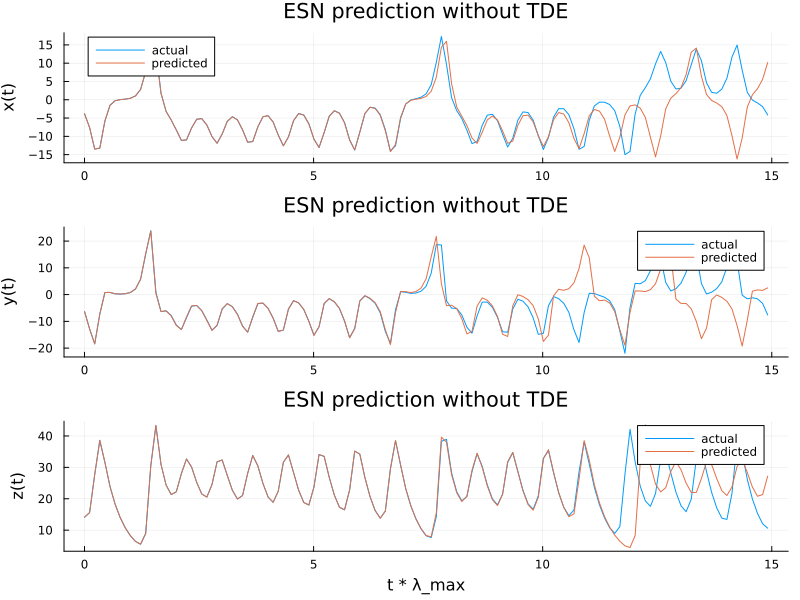

In [111]:
plot_prediction_sep(esn_x_1D,esn_y_1D,esn_z_1D, W_out_x_1D,  W_out_y_1D, W_out_z_1D,test_data_x_1D,test_data_y_1D,test_data_z_1D, l_max, "ESN prediction without TDE")

[14.110654878348956, 15.596105795509356, 27.713938865858378, 38.59689745202367, 31.58149118237152, 23.90747168761088, 18.275694375991304, 13.996299828890779, 10.722480557514908, 8.226272781471462, 6.388560429640604, 5.528097364510923, 8.944609056431684, 30.492123568508223, 43.349191660561395, 30.97719828293046, 24.372660146735722, 21.348482386878633, 22.216353329785083, 28.007173907396698, 32.67299365455809, 30.10435832183939, 25.236258955325304, 21.520439367308683, 20.538104395424522, 24.50783429886417, 31.74699033839222, 32.35420330808095, 27.441967083600346, 22.692579451817604, 19.922319779098046, 21.03128375048474, 28.07264520025286, 33.79998206796436, 30.467822359591292, 24.86034253853517, 20.57269907500184, 18.876251717651677, 22.41029177103261, 31.60545700803369, 33.94906382026581, 28.346290526495324, 22.706070304659868, 18.820924772156538, 18.00475689534253, 23.712848769245202, 34.07880561904491, 33.49866644116, 26.8241674510012, 21.158553566311387, 17.30297241597389, 16.480256

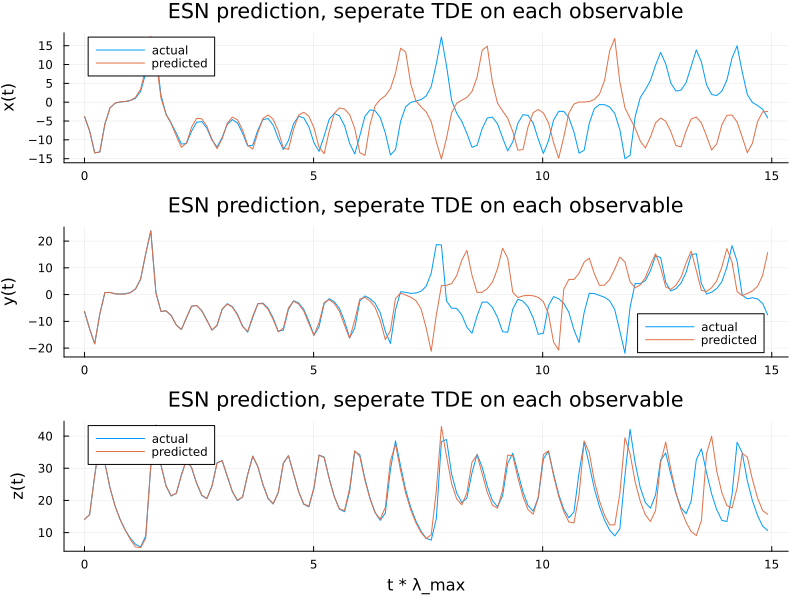

In [89]:
plot_prediction_sep(esn_x_emb, esn_y_emb,esn_z_emb, W_out_x_emb,W_out_y_emb, W_out_z_emb, test_x_data_emb,test_y_data_emb,test_z_data_emb, l_max, "ESN prediction, seperate TDE on each observable")